## Loading Libraries

In [1]:
# Libraries
import numpy as np
import sys
import time
import matplotlib.pylab as plt
%matplotlib inline
# importing S4
sys.path.append('/home/giovi/electrodynamics/st-matrix/S4/build/lib.linux-x86_64-3.4/')
import S4
# importing py-matrix parent folder
sys.path.append('/home/giovi/electrodynamics/st-matrix')
import py_matrix as pm

# multiprocessing
from multiprocessing import cpu_count
from joblib import Parallel, delayed
num_cores=cpu_count()

## inputs

In [2]:
#------building the optical constant database------
eps_db_out=pm.mat.generate_eps_db('/home/giovi/electrodynamics/st-matrix/py_matrix/materials/',ext='*.edb')
eps_files,eps_names,eps_db=eps_db_out['eps_files'],eps_db_out['eps_names'],eps_db_out['eps_db']

In [3]:
# stack material an thicknesses
stack=['e_vacuum','e_au','e_vacuum'];
d_list=[0.0,100.0,0.0];

# incident angles
theta_0=0.0
phi_0=0.0

# wavelengths
v_wl=np.linspace(400,800,num_cores)

# nanohole array r and pitch in nm
nh_p=500
nh_r=100
num=300

# drude metal parameters
w_p=8.95 # plasma frequency
gamma=0.02 # damping constant
f_m=1.06e-6 # medium magnetic coupling
v_f=1.4e6; # Fermi velocity
gamma_inf=0.069; # bulk damping constant
B=1000.0;
v_f=1.4e6;


# conversion factor
cf=1e-3

## S4 Solution

In [4]:
# initialize s4
S=S4.New(Lattice=((nh_p*cf,0),(0,nh_p*cf)), NumBasis=num)

# retrieving optical constants at wl from the database
e_list=np.array(pm.mat.db_to_eps(v_wl[0],eps_db,stack))

S.SetMaterial('Air',e_list[0])
S.SetMaterial('Au',e_list[1])

S.AddLayer('Inc',d_list[0]*cf,'Air')

S.AddLayer('Slab',d_list[1]*cf,'Air')
S.SetRegionCircle('Slab', 'Au', (0.0,0.0), nh_r*cf)

S.AddLayer('Sub',d_list[2]*cf,'Air')

S.SetExcitationPlanewave((theta_0,phi_0),1.0,0.0)

# S.SetOptions(PolarizationDecomposition = True,PolarizationBasis='Normal')
S.SetOptions(SubpixelSmoothing = True)

In [5]:
# define s4 functions
def fluxes_r(wl):
    
    S.SetExcitationPlanewave((theta_0,phi_0),1.0/np.sqrt(2.0),-1.0j/np.sqrt(2.0))
    
    # retrieving optical constants at wl from the database
    e_list=np.array(pm.mat.db_to_eps(wl,eps_db,stack))
    
    # gold tensor
    m_eff=np.zeros((3,3),dtype=np.complex128);
    e_xy=pm.mat.eps_xy_drude(wl, w_p, gamma_inf, B)
    m_eff[0,0]=e_list[1];m_eff[1,1]=e_list[1];m_eff[2,2]=e_list[1];
    m_eff[0,1]=e_xy
    m_eff[1,0]=-e_xy

    S.SetMaterial('Air',e_list[0])
    S.SetMaterial('Au',tuple(tuple(row) for row in m_eff))

    S.SetFrequency(1.0/(wl*cf))
    forw_1,back_1 = S.GetPowerFlux(Layer = 'Inc', zOffset = 0)
    forw_2,back_2 = S.GetPowerFlux(Layer = 'Sub', zOffset = 0)

    return forw_1,back_1,forw_2,back_2

def fluxes_l(wl):
    
    S.SetExcitationPlanewave((theta_0,phi_0),1.0/np.sqrt(2.0),1.0j/np.sqrt(2.0))
    
    # retrieving optical constants at wl from the database
    e_list=np.array(pm.mat.db_to_eps(wl,eps_db,stack))

    # gold tensor
    m_eff=np.zeros((3,3),dtype=np.complex128);
    e_xy=pm.mat.eps_xy_drude(wl, w_p, gamma_inf, B)
    m_eff[0,0]=e_list[1];m_eff[1,1]=e_list[1];m_eff[2,2]=e_list[1];
    m_eff[0,1]=e_xy
    m_eff[1,0]=-e_xy
    
    S.SetMaterial('Air',e_list[0])
    S.SetMaterial('Au',tuple(tuple(row) for row in m_eff))

    S.SetFrequency(1.0/(wl*cf))
    forw_1,back_1 = S.GetPowerFlux(Layer = 'Inc', zOffset = 0)
    forw_2,back_2 = S.GetPowerFlux(Layer = 'Sub', zOffset = 0)

    return forw_1,back_1,forw_2,back_2

In [6]:
pm.mat.eps_xy_drude(800.0, w_p, gamma_inf, B)

(-0.2208340120302999-2.4754666814937787j)

In [7]:
%%time
out_r=np.array(Parallel(n_jobs=num_cores)(delayed(fluxes_r)(wl) for wl in v_wl))
out_l=np.array(Parallel(n_jobs=num_cores)(delayed(fluxes_l)(wl) for wl in v_wl))

CPU times: user 1.03 s, sys: 943 ms, total: 1.97 s
Wall time: 2min 37s


In [8]:
v_R_r =   np.abs(out_r[:,1]/out_r[:,0])
v_T_r =   np.abs(out_r[:,2]/out_r[:,0])
v_A_r =   - np.log10(v_T_r)
v_R_l =   np.abs(out_l[:,1]/out_l[:,0])
v_T_l =   np.abs(out_l[:,2]/out_l[:,0])
v_A_l =   - np.log10(v_T_l)

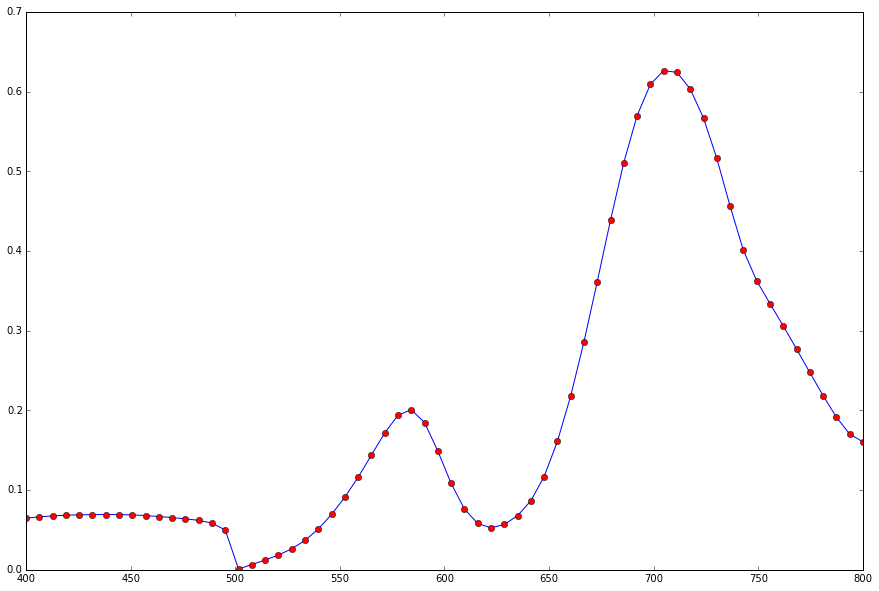

In [9]:
plt.figure(figsize=(15,10));
plt.plot(v_wl,v_R_r,
         v_wl,v_R_l,'ro');

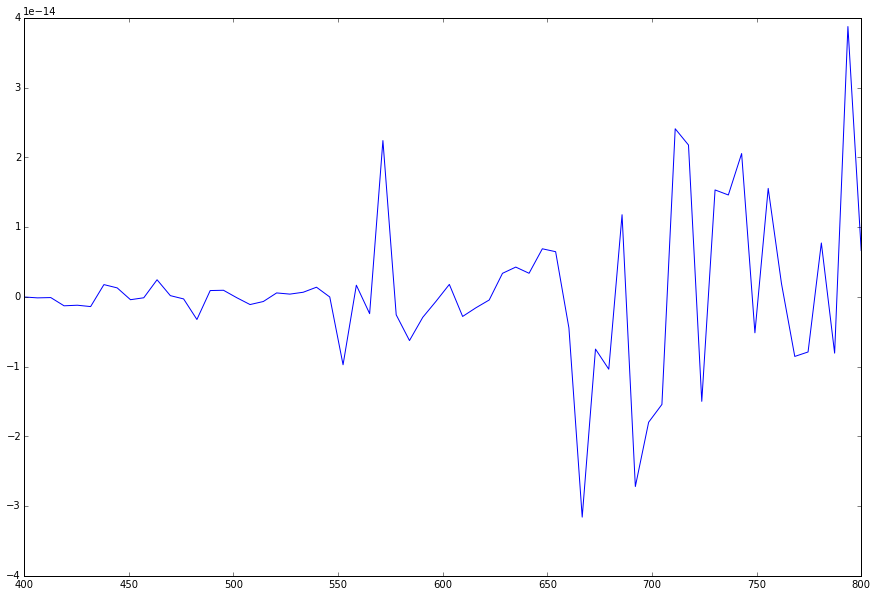

In [10]:
plt.figure(figsize=(15,10));
plt.plot(v_wl,v_R_r-v_R_l);